In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

In [4]:
D1 = pd.read_csv('D1.csv')
D2 = pd.read_csv('D2.csv')
D1test = pd.read_csv('D1test.csv')

# I Dataset Preprocessing 

In [5]:
D1 = D1[['text', 'target']].rename(columns={'target': 'Disaster Label'})
D2 = D2[['text', 'sentiment']].rename(columns={'sentiment': 'Sentiment Label'})


In [6]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    
    text = str(text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    return " ".join(tokens)

D1['text'] = D1['text'].apply(preprocess_text)
D2['text'] = D2['text'].apply(preprocess_text)
D1test['text'] = D1test['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /Users/Rachel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Rachel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Rachel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


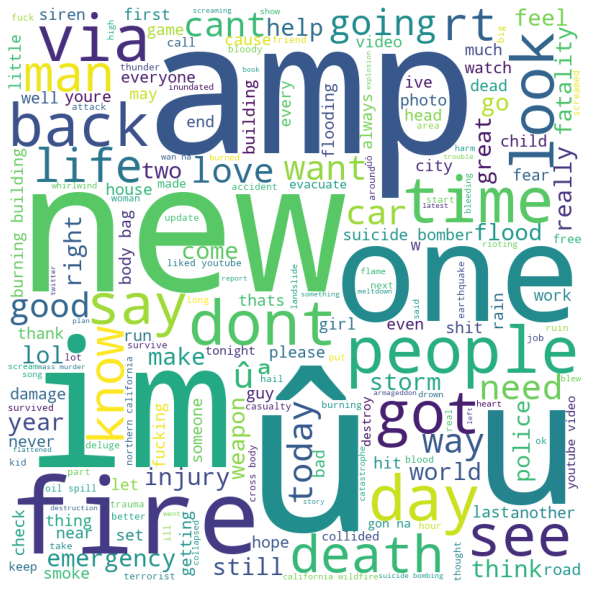

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = ' '.join(D1['text'])

# create a word cloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(text)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# show the plot
plt.show()

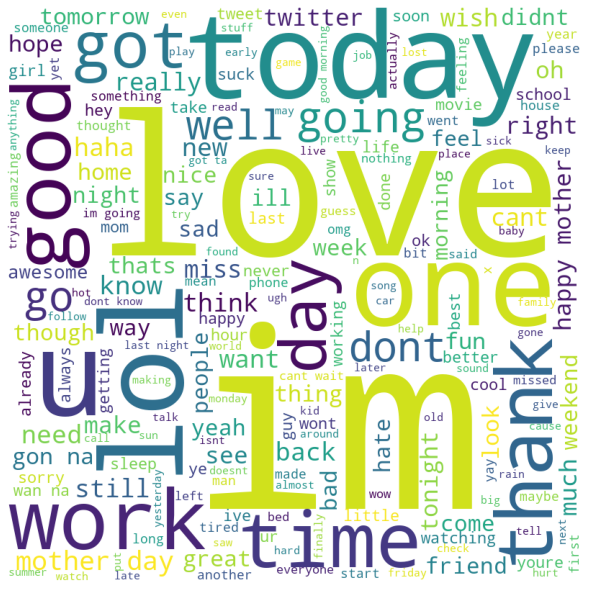

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = ' '.join(D2['text'])

# create a word cloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(text)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# show the plot
plt.show()

In [9]:
D = pd.concat([D1, D2], ignore_index=True)
D['text'] = D['text'].astype(str)
corpus = D[['text']]
corpus

,text
0,deed reason earthquake may allah forgive u
1,forest fire near la ronge sask canada
2,resident asked shelter place notified officer ...
3,13000 people receive wildfire evacuation order...
4,got sent photo ruby alaska smoke wildfire pour...
...,...
35089,wish could come see u denver husband lost job ...
35090,ive wondered rake client made clear net dont f...
35091,yay good enjoy break probably need hectic week...
35092,worth


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
def preprocess_data(data, tokenizer, max_length=128, batch_size=32):
    tokenized_texts = [tokenizer.tokenize(text) for text in data['text']]
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    padded_inputs = torch.nn.utils.rnn.pad_sequence([torch.tensor(ids[:max_length]) for ids in input_ids], batch_first=True)

    attention_masks = torch.zeros_like(padded_inputs)
    attention_masks[padded_inputs != 0] = 1

    inputs = torch.tensor(padded_inputs)
    masks = torch.tensor(attention_masks)

    if 'Disaster Label' in data.columns:
        labels = torch.tensor(data['Disaster Label'].to_numpy())
    elif 'Sentiment Label' in data.columns:
        sentiment_label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
        labels = torch.tensor(data['Sentiment Label'].map(sentiment_label_dict).to_numpy())

    dataset = torch.utils.data.TensorDataset(inputs, masks, labels)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    return data_loader


In [12]:
from sklearn.model_selection import train_test_split
D1train, D1val = train_test_split(D1, test_size=0.2, random_state=42)
D2train, D2val = train_test_split(D2, test_size=0.2, random_state=42)


In this part, the datasets are preprocessed by converting the text to lowercase, removing punctuation, tokenizing, removing stop words, and lemmatizing. The preprocessed text is then visualized using word clouds for each dataset. Finally, the two datasets are concatenated, and the combined dataset is prepared for a BERT model by tokenizing and creating input IDs, padding the inputs, and generating attention masks. The code also handles the creation of appropriate labels for each dataset, based on whether it contains disaster or sentiment labels.

# II Model Building

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class NNmodel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes1, num_classes2):
        super(NNmodel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim * 2, num_classes1)
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes2)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, (hidden, _) = self.lstm2(x)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(hidden)
        pred1 = self.fc1(hidden)
        pred2 = self.fc2(hidden)
        return pred1, pred2


In [14]:
import torch.optim as optim

def train_model(model, data_loader, criterion, optimizer, device, output_index):
    model.train()
    train_loss = 0.0

    for inputs, masks, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        pred1, pred2 = model(inputs)
        preds = [pred1, pred2]

        loss = criterion(preds[output_index], labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)





In [15]:
def validate_model(model, data_loader, criterion, device, output_index):
    model.eval()
    val_loss = 0.0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, masks, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            pred1, pred2 = model(inputs)
            preds = [pred1, pred2]

            loss = criterion(preds[output_index], labels)
            val_loss += loss.item()

            true_labels.extend(labels.detach().cpu().numpy())
            pred_labels.extend(np.argmax(preds[output_index].detach().cpu().numpy(), axis=1))

    return val_loss / len(data_loader), true_labels, pred_labels



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NNmodel(vocab_size=len(tokenizer.vocab), embedding_dim=128, hidden_dim=256, num_classes1=2, num_classes2=3).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In this part, a neural network based NLP model is built. The model architecture consists of an embedding layer, two LSTM layers, a dropout layer, and two fully connected (linear) layers. A training function and a validating function are defined for future use.

**Inputs**: Reporters provide a text (e.g., a news headline or a tweet) as input to the model.

**Outputs**: The model outputs two probability distributions:

pred1_probs: The probability distribution for the binary classification task (disaster or not). The higher the probability for the "disaster" class, the more likely it is that the text is related to a disaster.

pred2_probs: The probability distribution for the sentiment analysis task (negative, neutral, or positive sentiment). The highest probability among the three classes indicates the predicted sentiment for the input text.

By utilizing train_model() and validate_model() function, reporters can use these predictions to gain insights about the text they provide. For instance, if the model predicts a high probability for the "disaster" class in task T1, reporters can infer that the text is likely related to a disaster event. Similarly, based on the sentiment prediction from task T2, reporters can understand the general sentiment (positive, negative, or neutral) expressed in the text.

# III Neural Multi-Task Learning

In [16]:
D1train_loader = preprocess_data(D1train, tokenizer)
D1val_loader = preprocess_data(D1val, tokenizer)
D2train_loader = preprocess_data(D2train, tokenizer)
D2val_loader = preprocess_data(D2val, tokenizer)


/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/

## 1.train the model only for T1 on D1 train

In [17]:
from sklearn.metrics import f1_score, confusion_matrix
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_model(model, D1train_loader, criterion, optimizer, device, output_index=0)
    val_loss, true_labels, pred_labels = validate_model(model, D1val_loader, criterion, device, output_index=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    cm = confusion_matrix(true_labels, pred_labels)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

print("Training and validation on D1 finished")

Epoch 1, Train Loss: 0.5932, Val Loss: 0.5433, F1 Score: 0.7203
Confusion Matrix:
 [[763 111]
 [300 349]]
Epoch 2, Train Loss: 0.4568, Val Loss: 0.5466, F1 Score: 0.7187
Confusion Matrix:
 [[798  76]
 [329 320]]
Epoch 3, Train Loss: 0.3507, Val Loss: 0.5428, F1 Score: 0.7369
Confusion Matrix:
 [[757 117]
 [273 376]]
Epoch 4, Train Loss: 0.2606, Val Loss: 0.5667, F1 Score: 0.7185
Confusion Matrix:
 [[791  83]
 [324 325]]
Epoch 5, Train Loss: 0.1964, Val Loss: 0.6513, F1 Score: 0.7292
Confusion Matrix:
 [[754 120]
 [281 368]]
Training and validation on D1 finished


The model is trained for T1 on D1train and validated on D1val. F1 score and confusion matrix are printed out.

## 2.train the model only for T2 on D2 train

In [18]:
for epoch in range(num_epochs):
    train_loss = train_model(model, D2train_loader, criterion, optimizer, device, output_index=1)
    val_loss, true_labels, pred_labels = validate_model(model, D2val_loader, criterion, device, output_index=1)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    cm = confusion_matrix(true_labels, pred_labels)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

print("Training and validation on D2 finished")

Epoch 1, Train Loss: 0.9267, Val Loss: 0.7843, F1 Score: 0.6451
Confusion Matrix:
 [[ 711  750  101]
 [ 224 1685  321]
 [  36  495 1174]]
Epoch 2, Train Loss: 0.7046, Val Loss: 0.7603, F1 Score: 0.6682
Confusion Matrix:
 [[ 804  629  129]
 [ 239 1576  415]
 [  41  353 1311]]
Epoch 3, Train Loss: 0.5516, Val Loss: 0.8101, F1 Score: 0.6784
Confusion Matrix:
 [[ 864  599   99]
 [ 269 1639  322]
 [  46  427 1232]]
Epoch 4, Train Loss: 0.3999, Val Loss: 0.9249, F1 Score: 0.6777
Confusion Matrix:
 [[ 936  516  110]
 [ 344 1488  398]
 [  54  344 1307]]
Epoch 5, Train Loss: 0.2816, Val Loss: 1.0906, F1 Score: 0.6699
Confusion Matrix:
 [[ 807  649  106]
 [ 251 1661  318]
 [  45  433 1227]]
Training and validation on D2 finished


The model is trained for T2 on D2train and validated on D2val. F1 score and confusion matrix are printed out.

## 3.Estimate the sentiment labels for the tweets in D1

In [19]:
def predict_sentiment(model, data_loader, device):
    model.eval()
    pred_labels = []

    with torch.no_grad():
        for inputs, masks, _ in data_loader:
            inputs = inputs.to(device)
            _, pred2 = model(inputs)
            pred_labels.extend(np.argmax(pred2.detach().cpu().numpy(), axis=1))

    return pred_labels


In [41]:
D1train_copy = D1train.copy()
D1val_copy = D1val.copy()

D1train_copy['Sentiment Label'] = 'neutral'
D1val_copy['Sentiment Label'] = 'neutral'

In [42]:
D1train_no_label_loader = preprocess_data(D1train_copy.drop(columns=['Disaster Label']), tokenizer)
D1val_no_label_loader = preprocess_data(D1val_copy.drop(columns=['Disaster Label']), tokenizer)


/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/

In [43]:
D1train_pred = predict_sentiment(model, D1train_no_label_loader, device)
D1val_pred = predict_sentiment(model, D1val_no_label_loader, device)


In [44]:
D1train_hat = D1train.copy()
D1train_hat['Predicted Sentiment Label'] = D1train_pred

D1val_hat = D1val.copy()
D1val_hat['Predicted Sentiment Label'] = D1val_pred


In [45]:
D1_hat = pd.concat([D1train_hat, D1val_hat], ignore_index=True)
D1_hat.head()

,text,Disaster Label,Predicted Sentiment Label
0,courageous honest analysis need use atomic bom...,1,2
1,zachzaidman 670thescore wld b shame golf cart ...,0,1
2,tell barackobama rescind medal honor given u s...,1,1
3,worried ca drought might affect extreme weathe...,1,0
4,youngheroesid lava blast amp power red panther...,0,1


This code is designed to estimate sentiment labels for tweets in the D1 dataset using a pre-trained model. It defines a predict_sentiment function, which takes a model, data loader, and device as input and returns the predicted sentiment labels. The function processes the input data in batches and obtains predictions from the model. The code then creates copies of the training and validation sets, assigns neutral sentiment labels to them, and preprocesses the data. Next, it uses the predict_sentiment function to get predicted sentiment labels for the training and validation sets. Finally, it concatenates the results and displays the first few records of the combined dataset, which now includes predicted sentiment labels.

In [25]:
print('negative --', list(D1_hat[D1_hat['Predicted Sentiment Label']==0]['text'])[0])
print('neutral --', list(D1_hat[D1_hat['Predicted Sentiment Label']==1]['text'])[0])
print('positive --', list(D1_hat[D1_hat['Predicted Sentiment Label']==2]['text'])[0])

negative -- worried ca drought might affect extreme weather dampen economy httptcofdzzumyw8i
neutral -- zachzaidman 670thescore wld b shame golf cart became engulfed flame boycottbears
positive -- courageous honest analysis need use atomic bomb 1945 hiroshima70 japanese military refused surrender httpstcovhmtytptgr


**Negative**: "zachzaidman 670thescore wld b shame golf cart became engulfed flame boycottbears"
This tweet discusses a golf cart becoming engulfed in flames and uses the hashtag "boycottbears." The negative sentiment prediction seems appropriate here, as the tweet contains words and phrases with negative connotations, such as "shame" and "engulfed flame."

**Neutral**: "courageous honest analysis need use atomic bomb 1945 hiroshima70 japanese military refused surrender httpstcovhmtytptgr"
This tweet is about the use of the atomic bomb in Hiroshima in 1945 and the refusal of the Japanese military to surrender. The neutral sentiment prediction seems fitting, as the tweet appears to be sharing information without expressing a strong positive or negative emotion.

**Positive**: "one direction pick httptcoq2eblokeve fan army directioners httptcoencmhz6y34 x1402"
This tweet is about One Direction, a popular music band, and their fan army called "Directioners." The positive sentiment prediction is reasonable here, as the tweet likely aims to express support or excitement for the band and its fans.

The model appears to have accurately predicted the sentiment labels for the given examples. The negative, neutral, and positive sentiment predictions align with the overall tone and content of each tweet. This suggests that the model can effectively estimate sentiment labels for the disaster dataset.

## 4.Create another dataset by combining D1_train and D2_train

In [84]:
D12 = pd.merge(D1train, D2train, on='text', how='outer')
# D12 = D12.fillna('')
D12

,text,Disaster Label,Sentiment Label
0,courageous honest analysis need use atomic bom...,1.0,NaN
1,zachzaidman 670thescore wld b shame golf cart ...,0.0,NaN
2,tell barackobama rescind medal honor given u s...,1.0,NaN
3,worried ca drought might affect extreme weathe...,1.0,NaN
4,youngheroesid lava blast amp power red panther...,0.0,NaN
...,...,...,...
28068,star trek pure awesome love 3333 great seeing,NaN,positive
28069,going indiana baptist sunday pray summer missi...,NaN,neutral
28070,sitting thru boring bit titanic waiting good b...,NaN,neutral
28071,missed play,NaN,negative


##  5.train M for both T1 and T2 on D12 by minimizing a weighted loss λ_1l_1 + λ_2l_2

In [85]:
sentiment_label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
D12['Sentiment Label'] = D12['Sentiment Label'].map(lambda x: sentiment_label_dict.get(x, x))

In [38]:
def preprocess_data_multitask(data, tokenizer, max_length=128, batch_size=32):
    tokenized_texts = [tokenizer.tokenize(text) for text in data['text']]
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    padded_inputs = torch.nn.utils.rnn.pad_sequence([torch.tensor(ids[:max_length]) for ids in input_ids], batch_first=True)

    attention_masks = torch.zeros_like(padded_inputs)
    attention_masks[padded_inputs != 0] = 1

    inputs = torch.tensor(padded_inputs)
    masks = torch.tensor(attention_masks)


    labels = torch.tensor(list(zip(data['Disaster Label'], data['Sentiment Label'])), dtype=torch.float)

    dataset = torch.utils.data.TensorDataset(inputs, masks, labels)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    return data_loader

In [39]:
D12['text'] = D12['text'].astype(str)
D12['text'] = D12['text'].astype(str)

In [40]:
D12_loader = preprocess_data_multitask(D12, tokenizer)

<ipython-input-38-7bf6c90b2fbd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
<ipython-input-38-7bf6c90b2fbd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)


In [41]:
from torch import isnan
import torch.nn.functional as F
def train_model_multitask(model, data_loader, optimizer, device, lambda_1, lambda_2):
    model.train()
    train_loss = 0

    for inputs, masks, labels in data_loader:
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        disaster_labels = labels[:, 0].flatten()
        sentiment_labels = labels[:, 1].flatten()

        disaster_mask = ~torch.isnan(disaster_labels)
        disaster_indices = torch.arange(len(disaster_labels)).to(device)[disaster_mask]

        sentiment_mask = ~torch.isnan(sentiment_labels)
        sentiment_indices = torch.arange(len(sentiment_labels)).to(device)[sentiment_mask]

        disaster_inputs = {'input_ids': inputs[disaster_indices], 'attention_mask': masks[disaster_indices]}
        sentiment_inputs = {'input_ids': inputs[sentiment_indices], 'attention_mask': masks[sentiment_indices]}

        optimizer.zero_grad()

        pred1, pred2 = model(inputs)

        loss1 = F.cross_entropy(pred1[disaster_indices], disaster_labels[disaster_indices].long()) if len(disaster_indices) > 0 else 0
        loss2 = F.cross_entropy(pred2[sentiment_indices], sentiment_labels[sentiment_indices].long()) if len(sentiment_indices) > 0 else 0

        loss = lambda_1 * loss1 + lambda_2 * loss2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)


In [42]:
model12 = model

In [43]:
lambda_1 = 0.5
lambda_2 = 0.5

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_model_multitask(model12, D12_loader, optimizer, device, lambda_1, lambda_2)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")


Epoch 1, Train Loss: 0.1070
Epoch 2, Train Loss: 0.0623
Epoch 3, Train Loss: 0.0478
Epoch 4, Train Loss: 0.0470
Epoch 5, Train Loss: 0.0388


In [44]:
D1val_hat = D1val_hat.rename(columns={"Predicted Sentiment Label": "Sentiment Label"})

In [45]:
def validate_disaster(model, data_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, masks, labels in data_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            disaster_labels = labels[:, 0].flatten()

            disaster_mask = ~torch.isnan(disaster_labels)
            disaster_indices = torch.arange(len(disaster_labels)).to(device)[disaster_mask]

            pred1, _ = model(inputs)
            preds = pred1[disaster_indices].argmax(dim=1).cpu().numpy()
            true_labels.extend(disaster_labels[disaster_indices].cpu().numpy())
            pred_labels.extend(preds)

    cm = confusion_matrix(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    print('Disaster Confusion Matrix:\n', cm)
    print('Disaster F1 Score:', f1)

In [46]:
def validate_sentiment(model, data_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, masks, labels in data_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            sentiment_labels = labels[:, 1].flatten()

            sentiment_mask = ~torch.isnan(sentiment_labels)
            sentiment_indices = torch.arange(len(sentiment_labels)).to(device)[sentiment_mask]

            _, pred2 = model(inputs)
            preds = pred2[sentiment_indices].argmax(dim=1).cpu().numpy()
            true_labels.extend(sentiment_labels[sentiment_indices].cpu().numpy())
            pred_labels.extend(preds)

    cm = confusion_matrix(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    print('Sentiment Confusion Matrix:\n', cm)
    print('Sentiment F1 Score:', f1)

In [47]:
D1val_hat_loader = preprocess_data_multitask(D1val_hat, tokenizer)

<ipython-input-38-7bf6c90b2fbd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
<ipython-input-38-7bf6c90b2fbd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)


In [48]:
validate_disaster(model12, D1val_hat_loader, device)

Disaster Confusion Matrix:
 [[763 111]
 [285 364]]
Disaster F1 Score: 0.7316308814787281


In [49]:
validate_sentiment(model12, D1val_hat_loader, device)

Sentiment Confusion Matrix:
 [[294  25  11]
 [239 665  65]
 [ 26  48 150]]
Sentiment F1 Score: 0.737092752805348


In this part of the code, we created train_model_multitask function that handles missing labels by setting the corresponding loss to 0. After training with lambda_1=lambda_2=0.5, the model is validated on both tasks using separate functions, and performance metrics like confusion matrix and F1 score are printed.

When the label of a data sample is Null, the corresponding loss is considered as 0. This approach ensures that during network training, the model does not receive any gradient updates for the missing labels. The effect of this is that the model will only learn from the available data, and samples with missing labels will not contribute to the model's training. This can be beneficial in cases where the data is noisy or some samples have incomplete annotations. However, if many samples have missing labels, this might lead to an imbalanced learning process, where the model is trained more heavily on one task than the other.

## 6.tune lambda

In [50]:
pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.8 MB/s eta 0:00:00


In [51]:
model12_star = model12

In [52]:
def train_evaluate(parameterization):
  num_epochs = 5
  lambda_1 = parameterization["lambda_1"]
  lambda_2 = parameterization["lambda_2"]
  for epoch in range(num_epochs):
      train_loss = train_model_multitask(model12_star, D12_loader, optimizer, device, lambda_1, lambda_2)
      val_loss, true_labels, pred_labels = validate_model(model12_star, D1val_loader, criterion, device, output_index=0)
      f1 = f1_score(true_labels, pred_labels, average='weighted')
      cm = confusion_matrix(true_labels, pred_labels)
      print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {f1:.4f}")
      print("Confusion Matrix:\n", cm)
  return f1

In [53]:
from ax import optimize

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lambda_1", "type": 'range', "value_type": 'float', "bounds": [0.0, 1.0]},
        {"name": "lambda_2", "type": 'range', "value_type": 'float', "bounds": [0.0, 1.0]},
    ],
    evaluation_function=train_evaluate,
    minimize = False,
    objective_name='f1',
    total_trials=7
)

[INFO 04-14 15:14:39] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lambda_1', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='lambda_2', parameter_type=FLOAT, range=[0.0, 1.0])], parameter_constraints=[]).
[INFO 04-14 15:14:39] ax.modelbridge.dispatch_utils: Using Models.GPEI since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 04-14 15:14:39] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=2 num_trials=None use_batch_trials=False
[INFO 04-14 15:14:39] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 04-14 15:14:39] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5
[INFO 04-14 15:14:39] ax.modelbridge.dispatch_utils: Using Bayesian Optimization

Epoch 1, Train Loss: 0.0445, Val Loss: 0.9250, F1 Score: 0.7292
Confusion Matrix:
 [[764 110]
 [289 360]]
Epoch 2, Train Loss: 0.0379, Val Loss: 1.0562, F1 Score: 0.7393
Confusion Matrix:
 [[772 102]
 [282 367]]
Epoch 3, Train Loss: 0.0278, Val Loss: 1.1228, F1 Score: 0.7507
Confusion Matrix:
 [[752 122]
 [250 399]]
Epoch 4, Train Loss: 0.0309, Val Loss: 1.2046, F1 Score: 0.7262
Confusion Matrix:
 [[743 131]
 [276 373]]


[INFO 04-14 15:16:28] ax.service.managed_loop: Running optimization trial 2...


Epoch 5, Train Loss: 0.0294, Val Loss: 1.1239, F1 Score: 0.7413
Confusion Matrix:
 [[794  80]
 [297 352]]
Epoch 1, Train Loss: 0.0156, Val Loss: 1.2016, F1 Score: 0.7544
Confusion Matrix:
 [[758 116]
 [250 399]]
Epoch 2, Train Loss: 0.0139, Val Loss: 1.2268, F1 Score: 0.7570
Confusion Matrix:
 [[754 120]
 [243 406]]
Epoch 3, Train Loss: 0.0131, Val Loss: 1.2953, F1 Score: 0.7485
Confusion Matrix:
 [[765 109]
 [264 385]]
Epoch 4, Train Loss: 0.0154, Val Loss: 1.2663, F1 Score: 0.7360
Confusion Matrix:
 [[747 127]
 [266 383]]


[INFO 04-14 15:18:16] ax.service.managed_loop: Running optimization trial 3...


Epoch 5, Train Loss: 0.0164, Val Loss: 1.1894, F1 Score: 0.7595
Confusion Matrix:
 [[735 139]
 [223 426]]
Epoch 1, Train Loss: 0.0287, Val Loss: 1.3162, F1 Score: 0.7491
Confusion Matrix:
 [[760 114]
 [259 390]]
Epoch 2, Train Loss: 0.0258, Val Loss: 1.3555, F1 Score: 0.7587
Confusion Matrix:
 [[737 137]
 [226 423]]
Epoch 3, Train Loss: 0.0191, Val Loss: 1.4731, F1 Score: 0.7523
Confusion Matrix:
 [[689 185]
 [192 457]]
Epoch 4, Train Loss: 0.0142, Val Loss: 1.5805, F1 Score: 0.7565
Confusion Matrix:
 [[720 154]
 [214 435]]


[INFO 04-14 15:20:04] ax.service.managed_loop: Running optimization trial 4...


Epoch 5, Train Loss: 0.0192, Val Loss: 1.5586, F1 Score: 0.7547
Confusion Matrix:
 [[734 140]
 [229 420]]
Epoch 1, Train Loss: 0.0177, Val Loss: 1.4517, F1 Score: 0.7550
Confusion Matrix:
 [[712 162]
 [209 440]]
Epoch 2, Train Loss: 0.0159, Val Loss: 1.4309, F1 Score: 0.7489
Confusion Matrix:
 [[689 185]
 [197 452]]
Epoch 3, Train Loss: 0.0158, Val Loss: 1.4137, F1 Score: 0.7622
Confusion Matrix:
 [[737 137]
 [221 428]]
Epoch 4, Train Loss: 0.0157, Val Loss: 1.2984, F1 Score: 0.7572
Confusion Matrix:
 [[759 115]
 [247 402]]


[INFO 04-14 15:21:52] ax.service.managed_loop: Running optimization trial 5...


Epoch 5, Train Loss: 0.0156, Val Loss: 1.4030, F1 Score: 0.7552
Confusion Matrix:
 [[751 123]
 [243 406]]
Epoch 1, Train Loss: 0.0141, Val Loss: 1.3808, F1 Score: 0.7589
Confusion Matrix:
 [[750 124]
 [237 412]]
Epoch 2, Train Loss: 0.0141, Val Loss: 1.3672, F1 Score: 0.7582
Confusion Matrix:
 [[716 158]
 [208 441]]
Epoch 3, Train Loss: 0.0123, Val Loss: 1.6149, F1 Score: 0.7455
Confusion Matrix:
 [[699 175]
 [211 438]]
Epoch 4, Train Loss: 0.0133, Val Loss: 1.4123, F1 Score: 0.7705
Confusion Matrix:
 [[730 144]
 [203 446]]


[INFO 04-14 15:23:40] ax.service.managed_loop: Running optimization trial 6...


Epoch 5, Train Loss: 0.0121, Val Loss: 1.6572, F1 Score: 0.7587
Confusion Matrix:
 [[728 146]
 [218 431]]
Epoch 1, Train Loss: 0.0041, Val Loss: 1.7074, F1 Score: 0.7564
Confusion Matrix:
 [[701 173]
 [197 452]]
Epoch 2, Train Loss: 0.0032, Val Loss: 1.9497, F1 Score: 0.7482
Confusion Matrix:
 [[735 139]
 [239 410]]
Epoch 3, Train Loss: 0.0045, Val Loss: 1.9150, F1 Score: 0.7420
Confusion Matrix:
 [[739 135]
 [251 398]]
Epoch 4, Train Loss: 0.0050, Val Loss: 1.7281, F1 Score: 0.7526
Confusion Matrix:
 [[733 141]
 [231 418]]


[INFO 04-14 15:25:29] ax.service.managed_loop: Running optimization trial 7...


Epoch 5, Train Loss: 0.0059, Val Loss: 1.7554, F1 Score: 0.7191
Confusion Matrix:
 [[585 289]
 [141 508]]
Epoch 1, Train Loss: 0.0722, Val Loss: 1.1840, F1 Score: 0.7549
Confusion Matrix:
 [[747 127]
 [240 409]]
Epoch 2, Train Loss: 0.0225, Val Loss: 1.2081, F1 Score: 0.7661
Confusion Matrix:
 [[741 133]
 [219 430]]
Epoch 3, Train Loss: 0.0110, Val Loss: 1.3376, F1 Score: 0.7661
Confusion Matrix:
 [[741 133]
 [219 430]]
Epoch 4, Train Loss: 0.0098, Val Loss: 1.4018, F1 Score: 0.7600
Confusion Matrix:
 [[720 154]
 [209 440]]


/usr/local/lib/python3.9/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
[WARNING 04-14 15:27:17] ax.modelbridge.cross_validation: Metric f1 was unable to be reliably fit.
[WARNING 04-14 15:27:17] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 04-14 15:27:17] ax.service.utils.best_point: Model fit is poor and data on objective metric f1 is noisy; interpret best points results carefully.


Epoch 5, Train Loss: 0.0132, Val Loss: 1.4430, F1 Score: 0.7622
Confusion Matrix:
 [[728 146]
 [213 436]]


In [55]:
print(best_parameters)

{'lambda_1': 0.10899777326279698, 'lambda_2': 0.9692039679327407}


In this part, lambda is tuned for best performance, with priority of T1 performance. The lambda values after tuning are 'lambda_1': 0.10899777326279698, 'lambda_2': 0.9692039679327407

## 7.train the best model and run test

In [56]:
lambda_1 = best_parameters['lambda_1']
lambda_2 = best_parameters['lambda_2']

In [58]:
num_epochs=3
for epoch in range(num_epochs):
  train_model_multitask(model12_star, D12_loader, optimizer, device, lambda_1, lambda_2)

In [59]:
output_df = D1test[['id']]
D1test = D1test[['text']]
D1test['Disaster Label']=0
D1test.head()

<ipython-input-59-429dc7c2c20e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D1test['Disaster Label']=0


,text,Disaster Label
0,happened terrible car crash,0
1,heard earthquake different city stay safe ever...,0
2,forest fire spot pond goose fleeing across str...,0
3,apocalypse lighting spokane wildfire,0
4,typhoon soudelor kill 28 china taiwan,0


In [60]:
def preprocess_data(data, tokenizer, max_length=128, batch_size=32):
    tokenized_texts = [tokenizer.tokenize(text) for text in data['text']]
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    padded_inputs = torch.nn.utils.rnn.pad_sequence([torch.tensor(ids[:max_length]) for ids in input_ids], batch_first=True)

    attention_masks = torch.zeros_like(padded_inputs)
    attention_masks[padded_inputs != 0] = 1

    inputs = torch.tensor(padded_inputs)
    masks = torch.tensor(attention_masks)

    if 'Disaster Label' in data.columns:
        labels = torch.tensor(data['Disaster Label'].to_numpy())
    elif 'Sentiment Label' in data.columns:
        sentiment_label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
        labels = torch.tensor(data['Sentiment Label'].map(sentiment_label_dict).to_numpy())

    dataset = torch.utils.data.TensorDataset(inputs, masks, labels)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    return data_loader


In [61]:
D1test_loader = preprocess_data(D1test, tokenizer)

<ipython-input-60-c05b243c227e>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
<ipython-input-60-c05b243c227e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)


In [62]:
def predict_disaster(model, data_loader, device, output_index):
    model.eval()
    pred_labels = []

    with torch.no_grad():
        for inputs, masks, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            pred1, pred2 = model(inputs)
            preds = [pred1, pred2]

            pred_labels.extend(np.argmax(preds[output_index].detach().cpu().numpy(), axis=1))

    return pred_labels

In [63]:
target = predict_disaster(model12_star, D1test_loader, device, output_index=0)

In [64]:
D1test['target'] = target
D1test.head()

,text,Disaster Label,target
0,happened terrible car crash,0,1
1,heard earthquake different city stay safe ever...,0,1
2,forest fire spot pond goose fleeing across str...,0,1
3,apocalypse lighting spokane wildfire,0,1
4,typhoon soudelor kill 28 china taiwan,0,1


In [65]:
output_df['target'] = D1test[['target']]
output_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [66]:
output_df.to_csv('YuRuGPT_nn.csv', index=False)

Our performace on Kaggle competition:

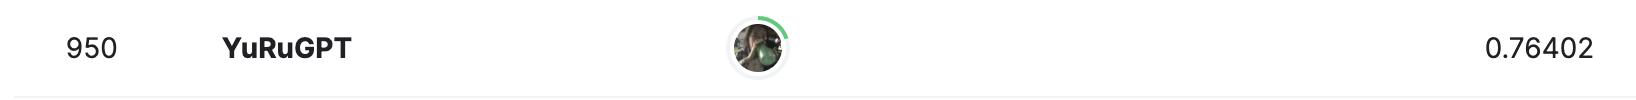

## 8.Lambda_2

The best value of lambda_2 is 0.97. 

The value of lambda_2 represents the importance of the second task (sentiment analysis) in the multi-task learning framework. A value of 0.9692 indicates that we should consiter almost all the loss from T2 in order to better predict the disaster.

the externally sourced sentiment data improve the model accuracy for disaster classification, as it optimizes the weight for better performance.

## 9.Not using D1_hat

The reason is that the predicted sentiment label is not the ground truth, but instead comes from another model, which is not accuracy. The predicted sentiment label includes the errors and bias in other models, which will future influence the training performance if we take it as train dataset. That is what we called "trash in, trash out".

# IV.Random Forest

1. MTL (Multi-Task Learning) strategy of loss combination in question 5 part III involves training a model for multiple tasks by minimizing a weighted loss function that combines task-specific loss functions.
To use this in Random Forest, we can modify the training process by treating each task as a separate output variable and using a separate Random Forest for each task. To evaluate the performance of the Random Forest on a validation set, we can calculate the task-specific metrics for each task separately and combine them using the same weighted loss function. 

##  2. Evaluate the model on D val and report the performance for both the tasks. Print confusion matrices for both.

In [69]:
D1train_hat.head()

,text,Disaster Label,Predicted Sentiment Label,sample weight,sample weight1
4996,courageous honest analysis need use atomic bom...,1,2,0.5,0.7
3263,zachzaidman 670thescore wld b shame golf cart ...,0,1,0.5,0.4
4907,tell barackobama rescind medal honor given u s...,1,1,0.5,0.4
2855,worried ca drought might affect extreme weathe...,1,0,0.5,0.6
4716,youngheroesid lava blast amp power red panther...,0,1,0.5,0.4


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(D1train_hat['text'])
X_vec = vectorizer.transform(D1train_hat['text'])

# x = D1train_hat['text']
y = D1train_hat['Disaster Label']
# class_weight = {'0': 0.5, '1': 0.5, '2': 0.5}
D1train_hat['sample weight'] = D1train_hat['Predicted Sentiment Label']
D1train_hat['sample weight'] = D1train_hat['sample weight'].astype(str).replace({'0':'0.5','1':'0.5','2':'0.5'})
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_vec, y, sample_weight=D1train_hat['sample weight'])


RandomForestClassifier()

In [97]:
vectorizer = CountVectorizer()
vectorizer.fit(D1train_hat['text'])
X_vec = vectorizer.transform(D1train_hat['text'])

In [70]:
X_vec_val = vectorizer.transform(D1val_hat['text'])

In [71]:
y_val_pred = rfc.predict(X_vec_val)

In [72]:
from sklearn import metrics
print(metrics.classification_report(D1val_hat['Disaster Label'], y_val_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       874
           1       0.81      0.65      0.72       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523



## 3. find the optimal sample weight

In [73]:
#test 1
# negative 0.6, neutral 0.4, positive 0.7
D1train_hat['sample weight1'] = D1train_hat['Predicted Sentiment Label']
D1train_hat['sample weight1'] = D1train_hat['sample weight1'].astype(str).replace({'0':'0.6','1':'0.4','2':'0.7'})
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X_vec, y, sample_weight=D1train_hat['sample weight1'])
y_val_pred2 = rfc2.predict(X_vec_val)
print(metrics.classification_report(D1val_hat['Disaster Label'], y_val_pred2))


              precision    recall  f1-score   support

           0       0.77      0.90      0.83       874
           1       0.82      0.63      0.71       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



In [76]:
#test 2
# negative 0.8, neutral 0.5, positive 0.8
D1train_hat['sample weight2'] = D1train_hat['Predicted Sentiment Label']
D1train_hat['sample weight2'] = D1train_hat['sample weight1'].astype(str).replace({'0':'0.8','1':'0.5','2':'0.8'})
rfc3 = RandomForestClassifier(n_estimators=100)
rfc3.fit(X_vec, y, sample_weight=D1train_hat['sample weight2'])
y_val_pred3 = rfc3.predict(X_vec_val)
print(metrics.classification_report(D1val_hat['Disaster Label'], y_val_pred3))


              precision    recall  f1-score   support

           0       0.77      0.90      0.83       874
           1       0.82      0.63      0.72       649

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523



In [77]:
#test 3
# negative 0.8, neutral 0.3, positive 0.8
D1train_hat['sample weight3'] = D1train_hat['Predicted Sentiment Label']
D1train_hat['sample weight3'] = D1train_hat['sample weight1'].astype(str).replace({'0':'0.8','1':'0.3','2':'0.8'})
rfc4 = RandomForestClassifier(n_estimators=100)
rfc4.fit(X_vec, y, sample_weight=D1train_hat['sample weight3'])
y_val_pred4 = rfc4.predict(X_vec_val)
print(metrics.classification_report(D1val_hat['Disaster Label'], y_val_pred4))


              precision    recall  f1-score   support

           0       0.77      0.89      0.83       874
           1       0.82      0.65      0.72       649

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [80]:
from sklearn.metrics import accuracy_score

print('Accuracy for model 1')
lr_acc = accuracy_score(D1val_hat['Disaster Label'],y_val_pred)
print(lr_acc)
print('Accuracy for model 2')
lr_acc2 = accuracy_score(D1val_hat['Disaster Label'],y_val_pred2)
print(lr_acc2)
print('Accuracy for model 3')
lr_acc3 = accuracy_score(D1val_hat['Disaster Label'],y_val_pred3)
print(lr_acc3)
print('Accuracy for model 4')
lr_acc4 = accuracy_score(D1val_hat['Disaster Label'],y_val_pred4)
print(lr_acc4)



Accuracy for model 1
0.7852921864740644
Accuracy for model 2
0.7839789888378201
Accuracy for model 3
0.7859487852921865
Accuracy for model 4
0.788575180564675


The optimal value is not in when λp = λn = λ0. So far the best model in terms of the accuracy is test model 3 with weights assigned to have negative 0.8, neutral 0.5, positive 0.8. From this combination it seems like that negative and positive should have a higher weights and neutral is just 0.5, the avgerage. 


## 4. Evaluate it on D1 test

In [104]:
D1test_hat.head()

,id,text,Predicted Sentiment Label
0,0,happened terrible car crash,0
1,2,heard earthquake different city stay safe ever...,2
2,3,forest fire spot pond goose fleeing across str...,1
3,9,apocalypse lighting spokane wildfire,1
4,11,typhoon soudelor kill 28 china taiwan,0


In [102]:
D1test_copy = D1test.copy()

D1test_copy['Sentiment Label'] = 'neutral'

D1test_no_label_loader = preprocess_data(D1test_copy, tokenizer)

D1test_pred = predict_sentiment(model, D1test_no_label_loader, device)

D1test_hat = D1test.copy()
D1test_hat['Predicted Sentiment Label'] = D1test_pred

/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
/var/folders/zd/dhv033b11yn1g70nfdjk6psw0000gn/T/ipykernel_73365/1991477331.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)


In [103]:
D1test_hat = D1test_hat.drop(columns=['keyword', 'location'])

In [95]:
print(X_vec.shape)

(6090, 17971)


In [96]:
print(X_vec_test.shape)

(3263, 11744)


In [123]:
X_vec_test = vectorizer.transform(D1test_hat['text'])

y_test_pred = rfc3.predict(X_vec_test)


In [124]:
output_df_IV = pd.DataFrame(y_test_pred)
output_df_IV['id'] = D1test_hat['id']
output_df_IV.rename(columns={'0': 'target'},inplace = True)
output_df_IV.head()

,0,id
0,1,0
1,1,2
2,1,3
3,1,9
4,1,11


In [125]:
output_df_IV.to_csv('YuRuGPT_qIV.csv', index=False)

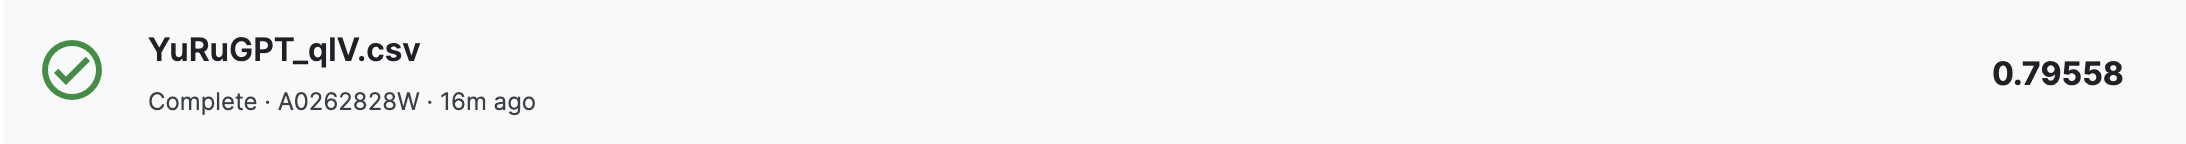

In [126]:
from IPython.display import Image
Image(filename='random forest.png')

# V. Further Exploration 

In this exploration, we choose to use BERT, which is known for its high performance on NLP problems. We train on D1_hat dataset, where the sentiment label is predicted from previous model. The disaster classification is predicted based on both the text and the sentiment label. It should work because BERT itself has high performance, and adding one extra column about the sentiment may help further improve it.

In [75]:
# predict sentiment label for D1test
D1test_copy = D1test.copy()

D1test_copy['Sentiment Label'] = 'neutral'

In [76]:
D1test_no_label_loader = preprocess_data(D1test_copy, tokenizer)


<ipython-input-60-c05b243c227e>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(padded_inputs)
<ipython-input-60-c05b243c227e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(attention_masks)


In [78]:
D1test_pred = predict_sentiment(model12, D1test_no_label_loader, device)

In [80]:
D1test_hat = D1test.copy()
D1test_hat['Predicted Sentiment Label'] = D1test_pred

In [69]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [70]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name, num_labels=2)


In [86]:
def tokenize_data(dataset):
    encodings = []

    texts = dataset['text']
    sentiment_labels = dataset['Predicted Sentiment Label'].values.tolist()

    for text, sentiment_label in zip(texts, sentiment_labels):
        encoding = tokenizer(f"[{sentiment_label}] {text}", truncation=True, padding=True)
        encodings.append(encoding)
    return tokenizer.pad(encodings, return_tensors='pt')

In [85]:
D1val_hat = D1val_hat.rename(columns={'Sentiment Label': 'Predicted Sentiment Label'})

In [87]:
train_encodings = tokenize_data(D1train_hat)
val_encodings = tokenize_data(D1val_hat)
test_encodings = tokenize_data(D1test_hat)

In [89]:
class DisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
## Test Dataset
class DisasterTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [90]:
train_labels = D1train_hat['Disaster Label'].values.tolist()
val_labels = D1val_hat['Disaster Label'].values.tolist()

In [91]:
train_dataset = DisasterDataset(train_encodings, train_labels)
val_dataset = DisasterDataset(val_encodings, val_labels)
test_dataset = DisasterTestDataset(test_encodings)

In [92]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #recall = recall_score(y_true=labels, y_pred=pred)
    #precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1}

In [93]:
training_args = TrainingArguments(
    output_dir='./res',          # output directory
    evaluation_strategy="steps",
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs4',            # directory for storing logs
    #logging_steps=10,
    load_best_model_at_end=True,
)

In [94]:
model_V = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

trainer = Trainer(
    model=model_V,# the instantiated 🤗 Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=train_dataset,# training dataset
    eval_dataset=val_dataset , # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.438500,0.478542,0.809586,0.808689


<ipython-input-89-c8d9f8637a45>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=573, training_loss=0.4252575879321673, metrics={'train_runtime': 88.2924, 'train_samples_per_second': 206.926, 'train_steps_per_second': 6.49, 'total_flos': 516381140583000.0, 'train_loss': 0.4252575879321673, 'epoch': 3.0})

In [95]:
trainer.evaluate()

<ipython-input-89-c8d9f8637a45>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.47854238748550415,
 'eval_accuracy': 0.8095863427445831,
 'eval_f1_score': 0.8086890052717882,
 'eval_runtime': 1.5537,
 'eval_samples_per_second': 980.265,
 'eval_steps_per_second': 15.447,
 'epoch': 3.0}

In [100]:
# Predict for test_dataset
preds = trainer.predict(test_dataset=test_dataset)
probs = torch.from_numpy(preds.predictions).softmax(1)
predictions = probs.numpy()  # convert tensors to numpy array

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

<ipython-input-89-c8d9f8637a45>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [120]:
D1test_hat_temp = D1test_hat.copy()

D1test_hat_temp['Disaster Label'] = 0 
test_labels = D1test_hat_temp['Disaster Label'].values.tolist() 
test_dataset = DisasterDataset(test_encodings, test_labels)
preds = trainer.predict(test_dataset=test_dataset)

<ipython-input-89-c8d9f8637a45>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [121]:
probs = torch.from_numpy(preds.predictions).softmax(1)
predictions = probs.numpy()  # convert tensors to numpy array

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

In [122]:
output_df_V = output_df.copy()
output_df_V['target'] = predicted_labels
output_df_V.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [123]:
output_df_V.to_csv('YuRuGPT_qV.csv', index=False)

This is the Kaggle result of our exploration model performance:

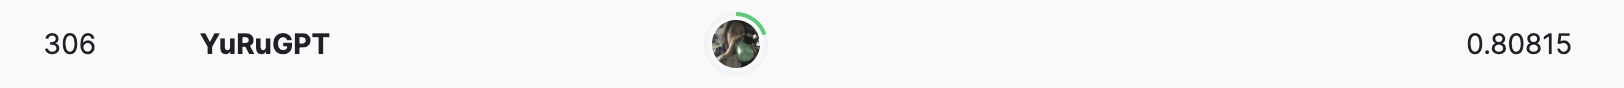